In [50]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from random import random
from collections import Counter
import scipy
from tqdm.auto import tqdm
from scipy.spatial import distance as d
import numpy as np
import json


def rand_color():
    color = (random(), random(), random())
    return color


def centroid_to_vec(centroid):
    return np.stack([centroid.x, centroid.y]).T


DATA = Path('../data')
RESULTS = Path('../results')
path_to_shape = DATA / 'road_segments' / 'road_segments.shp'
train_path = DATA / 'train.csv'
neigh_path = RESULTS / 'neigh.csv'

In [38]:
train = pd.read_csv(train_path)
road_segments = gpd.read_file(path_to_shape)

train_sids = train.road_segment_id.unique()

In [47]:
road_segments = road_segments[road_segments.segment_id.isin(train_sids)]

road_segments['start'] = road_segments.apply(lambda row: row.geometry.coords[0], 'columns')
road_segments['end'] = road_segments.apply(lambda row: row.geometry.coords[-1], 'columns')
road_segments['centroids'] = road_segments.geometry.centroid

n_neighbors = 5
sid_to_neighbors = dict()

for roadno in tqdm(road_segments.ROADNO):
    
    segment = road_segments[road_segments.ROADNO == roadno]
    
    dist_mat = d.squareform(d.pdist(centroid_to_vec(segment.centroid), 'euclidean'))
    
    for i, sid in enumerate(segment.segment_id):
        ii_neigh = np.argsort(dist_mat[i, :])[1:n_neighbors+1]
        sid_to_neighbors[sid] = list(segment.segment_id.iloc[ii_neigh])


In [48]:
with open(neigh_path, 'w') as j:
    json.dump(sid_to_neighbors, j)

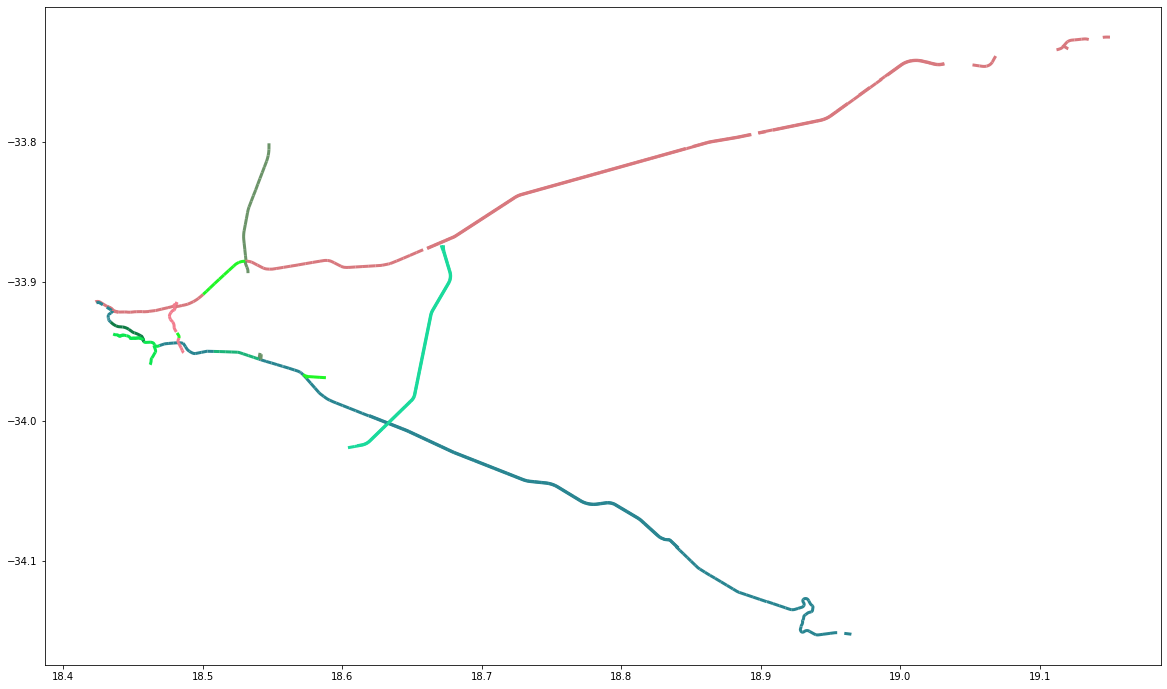

In [49]:
road_to_color = {road: rand_color() for road in road_segments.ROADNO.unique()}
colors = road_segments.apply(lambda row: road_to_color[row.ROADNO], 'columns')

fig = plt.figure(figsize=(20, 20))
ax = fig.gca()
ax = road_segments.plot(linewidth=3, color=colors, ax=ax)
plt.show()